In [1]:
# lets start gan
# download gan
import torchvision
download = False

train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, download=download)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=download)

print(len(train_ds), len(test_ds))
print(train_ds[0][0].size, train_ds[0][1])

50000 10000
(32, 32) 6


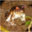

In [2]:
train_ds[0][0]

In [4]:
from torchvision.transforms import ToTensor

img_tensor = ToTensor()(train_ds[0][0])
img_tensor.size()

torch.Size([3, 32, 32])

In [13]:
img_tensor[:, 0:4, 4:8]

tensor([[[0.3843, 0.4667, 0.5451, 0.5686],
         [0.3451, 0.4706, 0.5020, 0.4980],
         [0.4314, 0.5059, 0.5098, 0.4745],
         [0.4510, 0.4588, 0.4471, 0.4118]],

        [[0.2863, 0.3569, 0.4196, 0.4314],
         [0.2000, 0.3216, 0.3490, 0.3373],
         [0.2824, 0.3608, 0.3647, 0.3216],
         [0.2745, 0.2902, 0.2824, 0.2431]],

        [[0.2039, 0.2471, 0.2941, 0.3137],
         [0.0824, 0.1686, 0.1765, 0.1725],
         [0.1608, 0.2118, 0.2157, 0.1843],
         [0.1294, 0.1373, 0.1451, 0.1294]]])

In [16]:
patch_size = 4
patches = img_tensor.view(3, 32//patch_size, patch_size, 32//patch_size, patch_size).permute(1, 3, 0, 2, 4).flatten(0, 1)
patches[1]

tensor([[[0.3843, 0.4667, 0.5451, 0.5686],
         [0.3451, 0.4706, 0.5020, 0.4980],
         [0.4314, 0.5059, 0.5098, 0.4745],
         [0.4510, 0.4588, 0.4471, 0.4118]],

        [[0.2863, 0.3569, 0.4196, 0.4314],
         [0.2000, 0.3216, 0.3490, 0.3373],
         [0.2824, 0.3608, 0.3647, 0.3216],
         [0.2745, 0.2902, 0.2824, 0.2431]],

        [[0.2039, 0.2471, 0.2941, 0.3137],
         [0.0824, 0.1686, 0.1765, 0.1725],
         [0.1608, 0.2118, 0.2157, 0.1843],
         [0.1294, 0.1373, 0.1451, 0.1294]]])

In [17]:
print(patches.size())

torch.Size([64, 3, 4, 4])


In [21]:
list(range(8))[::2]

[0, 2, 4, 6]

In [22]:
import torch

# patch merging
# for the time being flattening the patch because in actual model it is also going to be flattened
patches = patches.flatten(1)
n_cols = 8
n_rows = 8
new_patches = patches.view(n_rows, n_cols, -1)
tl = new_patches[::2, ::2, :]
tr = new_patches[::2, 1::2, :]
bl = new_patches[1::2, ::2, :]
br = new_patches[1::2, 1::2, :]

torch.cat([tl, tr, bl, br], dim=-1).size()

torch.Size([4, 4, 192])

In [23]:
import torch.nn as nn
class TMP(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(3, 3, 3, 1, 1)

  def forward(self, x):
    return self.conv(x)
  

tmp = TMP()
# get name of the layer
tmp._get_name()

'TMP'

In [24]:
# lets start gan
# download gan
import torchvision
download = False

train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=download)
test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=download)

print(len(train_ds), len(test_ds))
print(train_ds[0][0].size, train_ds[0][1])

60000 10000
(28, 28) 5


In [25]:
train_ds[0][0]

In [26]:
from torchvision.transforms import ToTensor
to_tensor = ToTensor()  
img_tensor = to_tensor(train_ds[0][0])
# pad the image to make it 32x32
pad = nn.ZeroPad2d(2)
img_tensor = pad(img_tensor)
img_tensor.size()

torch.Size([1, 32, 32])

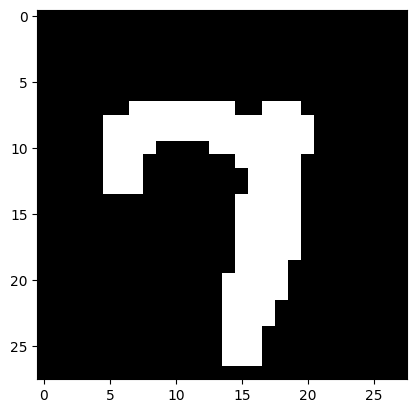

In [3]:
# visualize the image
import matplotlib.pyplot as plt
import numpy as np
import random

idx = random.randint(0, len(train_ds))
plt.imshow(np.array(train_ds[idx][0]), cmap='gray')

In [4]:
# GAN needs 2 models
# 1. Generator -> takes in noise and generates image
# 2. Discriminator -> takes in image and tells if it is real or fake

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
x = torch.arange(0, 10).float().view(2, 5).expand(1, 4, -1, -1)
print(x)
print(F.interpolate(x, scale_factor=2, mode='nearest').size())#, align_corners=False))

tensor([[[[0., 1., 2., 3., 4.],
          [5., 6., 7., 8., 9.]],

         [[0., 1., 2., 3., 4.],
          [5., 6., 7., 8., 9.]],

         [[0., 1., 2., 3., 4.],
          [5., 6., 7., 8., 9.]],

         [[0., 1., 2., 3., 4.],
          [5., 6., 7., 8., 9.]]]])
torch.Size([1, 4, 4, 10])


In [6]:
def calc_output_size(input_size, kernel_size, padding, stride):
  output_size = ((input_size - kernel_size + 2 * padding) // stride) + 1
  return output_size

calc_output_size(12, 3, 1, 1)

12

In [7]:
# Encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.l1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
    self.l2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
    self.l3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.l4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.l5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
    self.l6 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.l2(self.l1(x).relu()).relu()
    x = F.dropout2d(x, p=0.1)
    x = self.pool(x)
    x = self.l4(self.l3(x).relu()).relu()
    x = F.dropout2d(x, p=0.1)
    x = self.pool(x)
    x = self.l6(self.l5(x).relu()).relu()
    return x

In [8]:
enc = Encoder()
x = torch.randn(1, 1, 28, 28)
print(enc(x).size())

torch.Size([1, 16, 7, 7])


In [144]:
x = torch.randn(1, 4, 7, 7)
c = nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=3, padding=1)
print(c(x).size())

torch.Size([1, 4, 7, 7])


In [12]:
# Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    layers = []
    layers.append(nn.Sequential(
      nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
      nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    ))

    # layers.append(nn.Sequential(
    #   nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1),
    #   nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1)
    # ))

    layers.append(nn.Sequential(
      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
    ))

    layers.append(nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1))
    self.layers = nn.ModuleList(layers)
  
  def forward(self, x):
    # (1, 4, 7, 7) - conv -> (1, 4, 7, 7) - upsample -> (1, 4, 14, 14)
    # (1, 4, 14, 14) - conv -> (1, 4, 14, 14) - upsample -> (1, 4, 28, 28)
    # (1, 4, 28, 28) - conv -> (1, 1, 28, 28)
    for i, layer in enumerate(self.layers):
      x = layer(x)
      if i < len(self.layers) - 1:
        x = F.interpolate(F.gelu(x), scale_factor=2, mode='bilinear', align_corners=True)
        x = F.dropout2d(x, p=0.01, training=self.training)
      else:
        x = x.sigmoid()
    
    return x

torch.Size([1, 1, 28, 28])


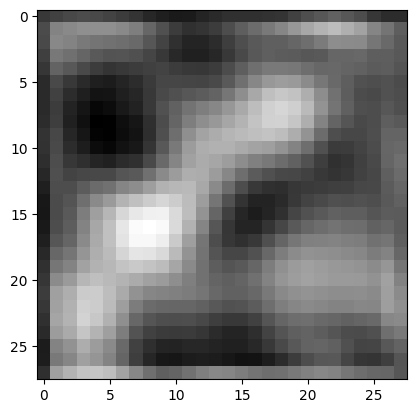

In [13]:
x = torch.randn(1, 16, 7, 7)
gen = Generator()
img = gen(x)
print(img.size())
# plot
plt.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

In [ ]:
x = torch.randn(1, 1, 28, 28)
pooler = nn.MaxPool2d(kernel_size=2, stride=2)
print(pooler(x).size())

In [14]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    layers = []
    layers.append(nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1))
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    layers.append(nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1))
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    layers.append(nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, padding=1))
    self.conv_layers = nn.ModuleList(layers)
    self.out_layer = nn.Linear(7 * 7, 1)

  def forward(self, x):
    for layer in self.conv_layers:
      x = layer(x).relu()
      x = F.dropout2d(x, p=0.01, training=self.training)
    x = x.flatten(1)
    x = self.out_layer(x)
    return x

In [15]:
img = torch.randn(1, 1, 28, 28)
disc = Discriminator()
print(disc(img).sigmoid())

tensor([[0.4851]], grad_fn=<SigmoidBackward0>)


In [ ]:
# generator loss  | Ref: https://neptune.ai/blog/gan-loss-functions
inp = torch.randn(1, 4, 7, 7)
img = gen(inp)
print('image size:', img.size())
disc_out = disc(img)
print('disc out:', disc_out)
gen_loss = -torch.log(disc_out.sigmoid())
print(gen_loss)

In [ ]:
# discriminator loss
from torchvision.transforms import ToTensor
real_img = ToTensor()(train_ds[0][0]).unsqueeze(0)
print('real image size:', real_img.size())
inp = torch.randn(1, 4, 7, 7)
fake_img = gen(inp)
print('fake image size:', fake_img.size())
real_disc_out = disc(real_img).sigmoid()
fake_disc_out = disc(fake_img).sigmoid()
print('real disc out:', real_disc_out)
print('fake disc out:', fake_disc_out)

disc_loss = -(torch.log(real_disc_out) + torch.log(1 - fake_disc_out)).mean()  # adding -ve sign
print(disc_loss)

In [ ]:
class EncGen(nn.Module):
  def __init__(self, enc, gen):
    super(EncGen, self).__init__()
    self.enc = enc
    self.gen = gen

  def forward(self, x):
    x = self.enc(x)
    x = self.gen(x)
    return x

In [ ]:
enc_gen = EncGen(Encoder(), Generator())
x = torch.randn(32, 1, 28, 28)
print(enc_gen(x).size())


In [56]:
# lets train
enc = Encoder()
gen = Generator()
disc = Discriminator()

# compiled models are 50-60 ms slower
# gen = torch.compile(Generator())
# disc = torch.compile(Discriminator())

device = torch.device('mps')
enc.to(device)
gen.to(device)
disc.to(device)

Discriminator(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_layer): Linear(in_features=49, out_features=1, bias=True)
)

In [57]:
enc_opt = torch.optim.AdamW(enc.parameters(), lr=3e-4)
gen_opt = torch.optim.AdamW(gen.parameters(), lr=3e-4)
disc_opt = torch.optim.AdamW(disc.parameters(), lr=3e-4)
offset = 0

Training for steps: 93750
Step:    0 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34688 | Time: 0.05 s
Step:    1 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34720 | Time: 0.04 s
Step:    2 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34752 | Time: 0.04 s
Step:    3 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34784 | Time: 0.03 s
Step:    4 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34816 | Time: 0.04 s
Step:    5 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34848 | Time: 0.04 s
Step:    6 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34880 | Time: 0.03 s
Step:    7 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34912 | Time: 0.03 s
Step:    8 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Offset: 34944 | Time: 0.03 s
Step:    9 | Enc loss: 0.0000 | Gen Loss: 0.6931 | Disc Loss: 0.6931 | Off

KeyboardInterrupt: 

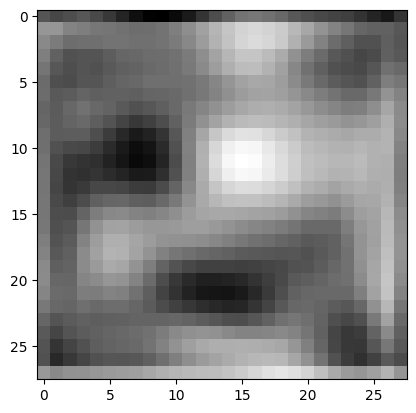

In [60]:
import time
from torchvision.transforms import ToTensor

# enc.to(device)
gen.to(device)
disc.to(device)

enc_opt.zero_grad()
gen_opt.zero_grad()
disc_opt.zero_grad()
BATCH_SIZE = 64


to_tensor = ToTensor()
all_real_imgs = torch.vstack([to_tensor(train_ds[i][0]).unsqueeze(0) for i in range(len(train_ds))])
# z = to_tensor(test_ds[0][0]).unsqueeze(0)
z = torch.randn(1, 16, 7, 7)

N_STEPS = len(all_real_imgs) * 100 // BATCH_SIZE
print("Training for steps:", N_STEPS)

for i in range(N_STEPS):
  start = time.monotonic()

  # train discriminator
  for params in disc.parameters(): params.requires_grad = True
  for params in gen.parameters(): params.requires_grad = False
  for params in enc.parameters(): params.requires_grad = False
  gen.eval()
  # enc.eval()
  disc.train()
  disc_opt.zero_grad()
  real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  real_img_disc_out = disc(real_imgs).sigmoid()
  
  with torch.no_grad():
    # latent_dim = enc(real_imgs)
    latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
    fake_imgs = gen(latent_dim)
  fake_disc_out = disc(fake_imgs).sigmoid()

  y_hat = torch.cat([real_img_disc_out, fake_disc_out])
  y_true = torch.cat([torch.ones_like(real_img_disc_out), torch.zeros_like(fake_disc_out)])
  disc_loss = F.binary_cross_entropy(y_hat, y_true)
  # disc_loss /= 2  # because we have 2x batch_size
  disc_loss.backward()
  disc_opt.step()
  disc_opt.zero_grad()

  # train generator
  for params in disc.parameters(): params.requires_grad = False
  for params in gen.parameters(): params.requires_grad = True
  for params in enc.parameters(): params.requires_grad = False
  gen.train()
  disc.eval()
  enc.eval()
  # real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  # latent_dim = enc(real_imgs).detach()
  latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
  fake_img = gen(latent_dim)
  disc_out = disc(fake_img).sigmoid()
  gen_loss = F.binary_cross_entropy(disc_out, torch.ones_like(disc_out))
  gen_loss.backward()
  gen_opt.step()
  gen_opt.zero_grad()

  # #train encoder
  # for params in gen.parameters(): params.requires_grad = True
  # for params in enc.parameters(): params.requires_grad = True
  # enc.train()
  # gen.train()
  # gen_opt.zero_grad()
  # enc_opt.zero_grad()
  # real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  # latent_dim = enc(real_imgs)
  # fake_imgs = gen(latent_dim)
  # enc_loss = F.mse_loss(fake_imgs.flatten(), real_imgs.flatten())
  # enc_loss.backward()
  # gen_loss = enc_loss.detach()
  # enc_opt.step()
  # gen_opt.step()
  # enc_opt.zero_grad()
  # gen_opt.zero_grad()
  enc_loss = torch.tensor(0.0)

  end = time.monotonic()

  offset = (offset + BATCH_SIZE // 2) % len(all_real_imgs)
  print(f"Step: {i:4d} | Enc loss: {enc_loss.item():.4f} | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f} | Offset: {offset} | Time: {end - start:.2f} s")

  if i % 1000 == 0:
    # enc.eval()
    gen.eval()
    img = gen(z.to(device))
    # latent_dim = enc(z.to(device))
    # img = gen(latent_dim)
    # save the image at "images/{i}.png"
    plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.savefig(f"images/{i}.png")

    enc.train()
    gen.train()



tensor([[0.4282]], grad_fn=<SigmoidBackward0>)


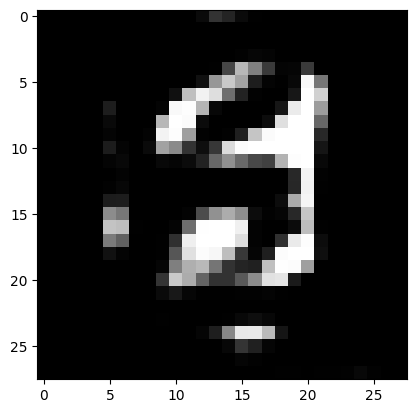

In [39]:
gen.eval()
disc.eval()

gen.to('cpu')
disc.to('cpu')

latent_dim = torch.randn(1, 16, 7, 7)
fake_img = gen(latent_dim)
disc_out = disc(fake_img).sigmoid()
print(disc_out)

# plot
plt.imshow(fake_img.view(28, 28).detach().numpy(), cmap='gray')

tensor([[0.4683]], grad_fn=<SigmoidBackward0>)


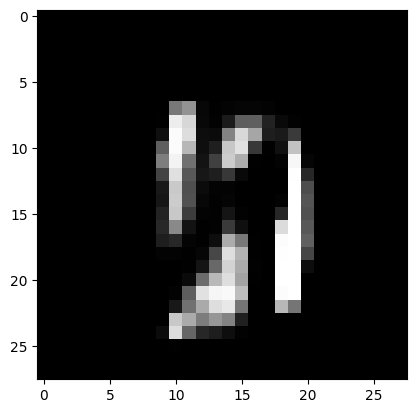

In [41]:
gen.eval()
disc.eval()

gen.to('cpu')
disc.to('cpu')

latent_dim = torch.randn(1, 16, 7, 7)
fake_img = gen(latent_dim)
disc_out = disc(fake_img).sigmoid()
print(disc_out)

# plot
plt.imshow(fake_img.view(28, 28).detach().numpy(), cmap='gray')

In [ ]:
enc.eval()
gen.eval()
disc.eval()

enc.to('cpu')
gen.to('cpu')
disc.to('cpu')

x = ToTensor()(train_ds[2][0]).unsqueeze(0)
latent_dim = enc(x)
fake_img = gen(latent_dim)
disc_out = disc(fake_img).sigmoid()
print(disc_out)

# plot
plt.imshow(img.view(28, 28).detach().numpy(), cmap='gray')

In [ ]:
print(disc(real_img).sigmoid())
plt.imshow(real_img.view(28, 28).detach().numpy(), cmap='gray')

In [63]:
# just select all images with label 3
idxs = [i for i in range(len(train_ds)) if train_ds[i][1] == 3]
# ds_3 = train_ds[idxs]
train_ds[idxs[0]][0]

In [68]:
# lets train
enc = Encoder()
gen = Generator()
disc = Discriminator()

# compiled models are 50-60 ms slower
# gen = torch.compile(Generator())
# disc = torch.compile(Discriminator())

device = torch.device('mps')
enc.to(device)
gen.to(device)
disc.to(device)

Discriminator(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_layer): Linear(in_features=49, out_features=1, bias=True)
)

In [69]:
enc_opt = torch.optim.AdamW(enc.parameters(), lr=3e-4)
gen_opt = torch.optim.AdamW(gen.parameters(), lr=3e-4)
disc_opt = torch.optim.AdamW(disc.parameters(), lr=3e-4)
offset = 0

Training for steps: 9579
Step:    0 | Enc loss: 0.0000 | Gen Loss: 0.7434 | Disc Loss: 0.3430 | Offset: 32 | Time: 0.04 s
Step:    1 | Enc loss: 0.0000 | Gen Loss: 0.7433 | Disc Loss: 0.3418 | Offset: 64 | Time: 0.04 s
Step:    2 | Enc loss: 0.0000 | Gen Loss: 0.7431 | Disc Loss: 0.3417 | Offset: 96 | Time: 0.04 s
Step:    3 | Enc loss: 0.0000 | Gen Loss: 0.7429 | Disc Loss: 0.3422 | Offset: 128 | Time: 0.04 s
Step:    4 | Enc loss: 0.0000 | Gen Loss: 0.7427 | Disc Loss: 0.3420 | Offset: 160 | Time: 0.04 s
Step:    5 | Enc loss: 0.0000 | Gen Loss: 0.7426 | Disc Loss: 0.3422 | Offset: 192 | Time: 0.03 s
Step:    6 | Enc loss: 0.0000 | Gen Loss: 0.7425 | Disc Loss: 0.3420 | Offset: 224 | Time: 0.04 s
Step:    7 | Enc loss: 0.0000 | Gen Loss: 0.7424 | Disc Loss: 0.3418 | Offset: 256 | Time: 0.03 s
Step:    8 | Enc loss: 0.0000 | Gen Loss: 0.7422 | Disc Loss: 0.3412 | Offset: 288 | Time: 0.03 s
Step:    9 | Enc loss: 0.0000 | Gen Loss: 0.7421 | Disc Loss: 0.3411 | Offset: 320 | Time: 0.03 

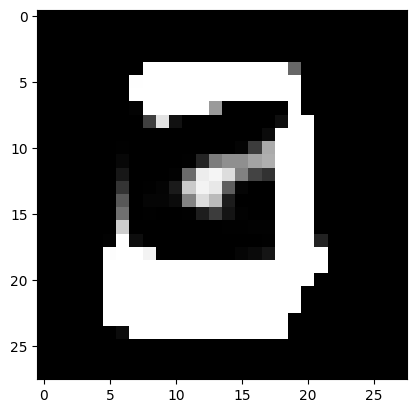

In [70]:
import time
from torchvision.transforms import ToTensor

# enc.to(device)
gen.to(device)
disc.to(device)

enc_opt.zero_grad()
gen_opt.zero_grad()
disc_opt.zero_grad()
BATCH_SIZE = 64


to_tensor = ToTensor()
all_real_imgs = torch.vstack([to_tensor(train_ds[i][0]).unsqueeze(0) for i in idxs])
# z = to_tensor(test_ds[0][0]).unsqueeze(0)
z = torch.randn(1, 16, 7, 7)

N_STEPS = len(all_real_imgs) * 100 // BATCH_SIZE
print("Training for steps:", N_STEPS)

for i in range(N_STEPS):
  start = time.monotonic()

  # train discriminator
  for params in disc.parameters(): params.requires_grad = True
  for params in gen.parameters(): params.requires_grad = False
  for params in enc.parameters(): params.requires_grad = False
  gen.eval()
  # enc.eval()
  disc.train()
  disc_opt.zero_grad()
  real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  real_img_disc_out = disc(real_imgs).sigmoid()
  
  with torch.no_grad():
    # latent_dim = enc(real_imgs)
    latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
    fake_imgs = gen(latent_dim)
  fake_disc_out = disc(fake_imgs).sigmoid()

  y_hat = torch.cat([real_img_disc_out, fake_disc_out])
  y_true = torch.cat([torch.ones_like(real_img_disc_out), torch.zeros_like(fake_disc_out)])
  disc_loss = F.binary_cross_entropy(y_hat, y_true)
  disc_loss /= 2  # because we have 2x batch_size
  disc_loss.backward()
  disc_opt.step()
  disc_opt.zero_grad()

  # train generator
  for params in disc.parameters(): params.requires_grad = False
  for params in gen.parameters(): params.requires_grad = True
  for params in enc.parameters(): params.requires_grad = False
  gen.train()
  disc.eval()
  enc.eval()
  # real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  # latent_dim = enc(real_imgs).detach()
  latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
  fake_img = gen(latent_dim)
  disc_out = disc(fake_img).sigmoid()
  gen_loss = F.binary_cross_entropy(disc_out, torch.ones_like(disc_out))
  gen_loss.backward()
  gen_opt.step()
  gen_opt.zero_grad()

  # #train encoder
  # for params in gen.parameters(): params.requires_grad = True
  # for params in enc.parameters(): params.requires_grad = True
  # enc.train()
  # gen.train()
  # gen_opt.zero_grad()
  # enc_opt.zero_grad()
  # real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  # latent_dim = enc(real_imgs)
  # fake_imgs = gen(latent_dim)
  # enc_loss = F.mse_loss(fake_imgs.flatten(), real_imgs.flatten())
  # enc_loss.backward()
  # gen_loss = enc_loss.detach()
  # enc_opt.step()
  # gen_opt.step()
  # enc_opt.zero_grad()
  # gen_opt.zero_grad()
  enc_loss = torch.tensor(0.0)

  end = time.monotonic()

  offset = (offset + BATCH_SIZE // 2) % len(all_real_imgs)
  print(f"Step: {i:4d} | Enc loss: {enc_loss.item():.4f} | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f} | Offset: {offset} | Time: {end - start:.2f} s")

  if i % 1000 == 0:
    # enc.eval()
    gen.eval()
    img = gen(z.to(device))
    # latent_dim = enc(z.to(device))
    # img = gen(latent_dim)
    # save the image at "images/{i}.png"
    plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.savefig(f"images/{i}.png")

    enc.train()
    gen.train()



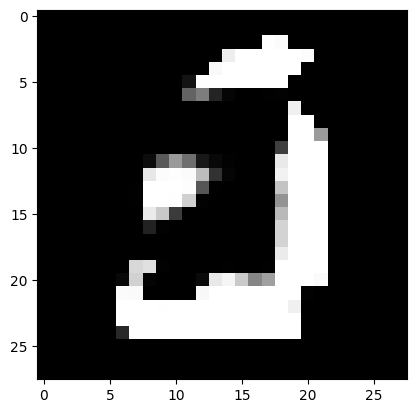

In [71]:
gen.eval()
img = gen(z.to(device))
plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')

In [72]:
# lets train
gen = Generator()
disc = Discriminator()

target_gen = Generator()
target_disc = Discriminator()

# copy weights from gen to target_gen
target_gen.load_state_dict(gen.state_dict())
target_disc.load_state_dict(disc.state_dict())

# compiled models are 50-60 ms slower
# gen = torch.compile(Generator())
# disc = torch.compile(Discriminator())

device = torch.device('mps')
gen.to(device)
disc.to(device)
target_gen.to(device)
target_disc.to(device)

Discriminator(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_layer): Linear(in_features=49, out_features=1, bias=True)
)

In [73]:
gen_opt = torch.optim.AdamW(gen.parameters(), lr=3e-3)
disc_opt = torch.optim.AdamW(disc.parameters(), lr=3e-3)

Training for steps: 9579
Step:    0 | Gen Loss: 0.8469 | Disc Loss: 0.3160 | Offset: 10 | Time: 0.17 s
Step:    1 | Gen Loss: 0.8444 | Disc Loss: 0.3510 | Offset: 42 | Time: 0.04 s
Step:    2 | Gen Loss: 0.8443 | Disc Loss: 0.3511 | Offset: 74 | Time: 0.04 s
Step:    3 | Gen Loss: 0.8472 | Disc Loss: 0.3512 | Offset: 106 | Time: 0.04 s
Step:    4 | Gen Loss: 0.8457 | Disc Loss: 0.3516 | Offset: 138 | Time: 0.05 s
Step:    5 | Gen Loss: 0.8461 | Disc Loss: 0.3510 | Offset: 170 | Time: 0.04 s
Step:    6 | Gen Loss: 0.8447 | Disc Loss: 0.3508 | Offset: 202 | Time: 0.04 s
Step:    7 | Gen Loss: 0.8458 | Disc Loss: 0.3508 | Offset: 234 | Time: 0.04 s
Step:    8 | Gen Loss: 0.8472 | Disc Loss: 0.3510 | Offset: 266 | Time: 0.04 s
Step:    9 | Gen Loss: 0.8471 | Disc Loss: 0.3512 | Offset: 298 | Time: 0.03 s
Step:   10 | Gen Loss: 0.8456 | Disc Loss: 0.3502 | Offset: 330 | Time: 0.04 s
Step:   11 | Gen Loss: 0.8455 | Disc Loss: 0.3507 | Offset: 362 | Time: 0.03 s
Step:   12 | Gen Loss: 0.8464 

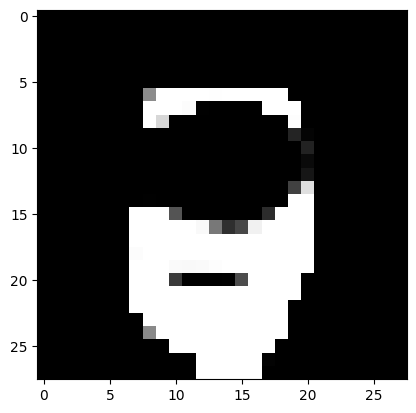

In [75]:
import time
from torchvision.transforms import ToTensor

# enc.to(device)
gen.to(device)
disc.to(device)
target_gen.to(device)
target_disc.to(device)

gen_opt.zero_grad()
disc_opt.zero_grad()
BATCH_SIZE = 64

tau = 5e-2
for params in target_gen.parameters(): params.requires_grad = False
for params in target_disc.parameters(): params.requires_grad = False

to_tensor = ToTensor()
all_real_imgs = torch.vstack([to_tensor(train_ds[i][0]).unsqueeze(0) for i in idxs])
# z = to_tensor(test_ds[0][0]).unsqueeze(0)
z = torch.randn(1, 16, 7, 7)

N_STEPS = len(all_real_imgs) * 100 // BATCH_SIZE
print("Training for steps:", N_STEPS)

for i in range(N_STEPS):
  start = time.monotonic()

  # train discriminator
  for params in disc.parameters(): params.requires_grad = True
  for params in gen.parameters(): params.requires_grad = False
  gen.eval()
  disc.train()
  disc_opt.zero_grad()
  real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  real_img_disc_out = disc(real_imgs).sigmoid()
  
  with torch.no_grad():
    # latent_dim = enc(real_imgs)
    latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
    fake_imgs = target_gen(latent_dim)
  fake_disc_out = disc(fake_imgs).sigmoid()

  y_hat = torch.cat([real_img_disc_out, fake_disc_out])
  y_true = torch.cat([torch.ones_like(real_img_disc_out), torch.zeros_like(fake_disc_out)])
  disc_loss = F.binary_cross_entropy(y_hat, y_true)
  disc_loss /= 2  # because we have 2x batch_size
  disc_loss.backward()
  disc_opt.step()
  disc_opt.zero_grad()

  # train generator
  for params in disc.parameters(): params.requires_grad = False
  for params in gen.parameters(): params.requires_grad = True
  gen.train()
  disc.eval()
  latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
  fake_img = gen(latent_dim)
  disc_out = target_disc(fake_img).sigmoid()
  gen_loss = F.binary_cross_entropy(disc_out, torch.ones_like(disc_out))
  gen_loss.backward()
  gen_opt.step()
  gen_opt.zero_grad()

  end = time.monotonic()
  offset = (offset + BATCH_SIZE // 2) % len(all_real_imgs)

  # soft update target networks
  for target_params, params in zip(target_gen.parameters(), gen.parameters()):
    target_params.data = tau * params.data + (1 - tau) * target_params.data
  for target_params, params in zip(target_disc.parameters(), disc.parameters()):
    target_params.data = tau * params.data + (1 - tau) * target_params.data

  print(f"Step: {i:4d} | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f} | Offset: {offset} | Time: {end - start:.2f} s")

  if i % 1000 == 0:
    img = target_gen(z.to(device))
    plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.savefig(f"images/{i}.png")


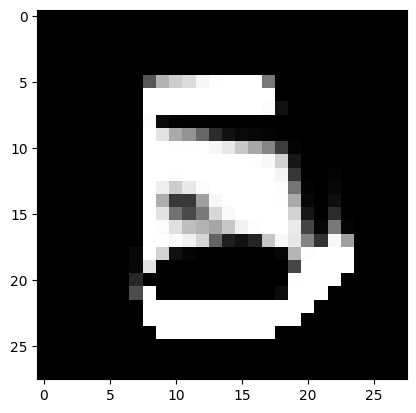

In [76]:
gen.eval()
img = gen(z.to(device))
plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')

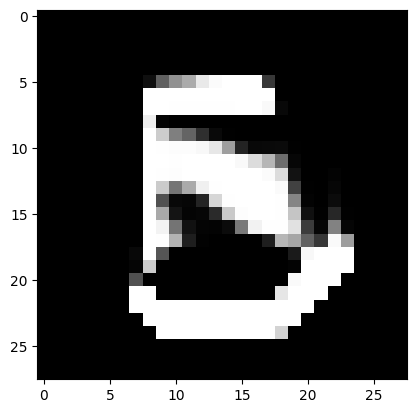

In [77]:
target_gen.eval()
img = target_gen(z.to(device))
plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')

In [78]:
# early stopping

In [ ]:
# lets train
gen = Generator()
disc = Discriminator()

# compiled models are 50-60 ms slower
# gen = torch.compile(Generator())
# disc = torch.compile(Discriminator())

device = torch.device('mps')
gen.to(device)
disc.to(device)

In [ ]:
gen_opt = torch.optim.AdamW(gen.parameters(), lr=3e-3)
disc_opt = torch.optim.AdamW(disc.parameters(), lr=3e-3)

Training for steps: 9579
Step:    0  | Gen Loss: 2.8144 | Disc Loss: 0.0903 | Offset: 6119 | Time: 0.18 s


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rohan/1_Project/making_vq_gan/images/0.png'

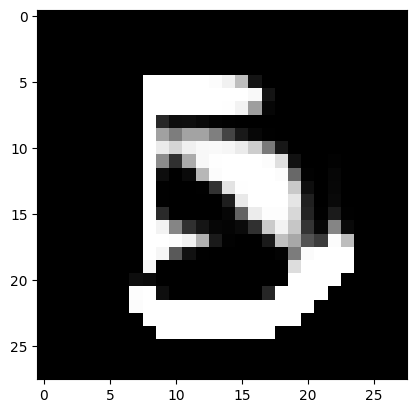

In [79]:
import time
from torchvision.transforms import ToTensor

# enc.to(device)
gen.to(device)
disc.to(device)

gen_opt.zero_grad()
disc_opt.zero_grad()
BATCH_SIZE = 64

to_tensor = ToTensor()
all_real_imgs = torch.vstack([to_tensor(train_ds[i][0]).unsqueeze(0) for i in idxs])
# z = to_tensor(test_ds[0][0]).unsqueeze(0)
z = torch.randn(1, 16, 7, 7)
validation_z = torch.randn(BATCH_SIZE*2, 16, 7, 7)

N_STEPS = len(all_real_imgs) * 100 // BATCH_SIZE
print("Training for steps:", N_STEPS)

for i in range(N_STEPS):
  start = time.monotonic()

  # train discriminator
  for params in disc.parameters(): params.requires_grad = True
  for params in gen.parameters(): params.requires_grad = False
  gen.eval()
  disc.train()
  disc_opt.zero_grad()
  real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)
  real_img_disc_out = disc(real_imgs).sigmoid()
  
  with torch.no_grad():
    # latent_dim = enc(real_imgs)
    latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
    fake_imgs = gen(latent_dim)
  fake_disc_out = disc(fake_imgs).sigmoid()

  y_hat = torch.cat([real_img_disc_out, fake_disc_out])
  y_true = torch.cat([torch.ones_like(real_img_disc_out), torch.zeros_like(fake_disc_out)])
  disc_loss = F.binary_cross_entropy(y_hat, y_true)
  disc_loss /= 2  # because we have 2x batch_size
  disc_loss.backward()
  disc_opt.step()
  disc_opt.zero_grad()

  # train generator
  for params in disc.parameters(): params.requires_grad = False
  for params in gen.parameters(): params.requires_grad = True
  gen.train()
  disc.eval()
  latent_dim = torch.randn(BATCH_SIZE, 16, 7, 7).to(device)
  fake_img = gen(latent_dim)
  disc_out = disc(fake_img).sigmoid()
  gen_loss = F.binary_cross_entropy(disc_out, torch.ones_like(disc_out))
  gen_loss.backward()
  gen_opt.step()
  gen_opt.zero_grad()

  end = time.monotonic()
  offset = (offset + BATCH_SIZE // 2) % len(all_real_imgs)


  # validation loss
  fake_imgs = gen(validation_z.to(device))
  fake_imgs_disc_out = disc(fake_imgs).sigmoid()
  val_loss = F.binary_cross_entropy(fake_imgs_disc_out, torch.ones_like(fake_imgs_disc_out)).item()


  print(f"Step: {i:4d} | Val Loss: {val_loss.item():.4f} | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f} | Offset: {offset} | Time: {end - start:.2f} s")

  if i % 1000 == 0:
    img = target_gen(z.to(device))
    plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.savefig(f"images/{i}.png")


In [80]:
len(idxs)

6131

In [226]:
# Encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.l1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
    self.l2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding=1)
    self.l3 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
    self.l4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
    self.l5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.l1(x).relu()
    x = x + self.l2(x).relu()
    x = F.dropout2d(x, p=0.1, training=self.training)
    x = self.pool(x)
    x = self.l3(x).relu()
    x = x + self.l4(x).relu()
    x = F.dropout2d(x, p=0.1, training=self.training)
    x = self.pool(x)
    x = self.l5(x).relu()

    # # chagne the activation to gelu
    # x = F.gelu(self.l1(x))
    # x = x + F.gelu(self.l2(x))
    # x = F.dropout2d(x, p=0.1, training=self.training)
    # x = self.pool(x)
    # x = F.gelu(self.l3(x))
    # x = x + F.gelu(self.l4(x))
    # x = F.dropout2d(x, p=0.1, training=self.training)
    # x = self.pool(x)
    # x = F.gelu(self.l5(x))
    return x

In [230]:
# Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    layers = []

    layers.append(nn.Sequential(
      nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
      nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
      nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    ))

    layers.append(nn.Sequential(
      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
      nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
      nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
    ))

    layers.append(nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1))
    self.layers = nn.ModuleList(layers)
  
  def forward(self, x):
    # (1, 4, 7, 7) - conv -> (1, 4, 7, 7) - upsample -> (1, 4, 14, 14)
    # (1, 4, 14, 14) - conv -> (1, 4, 14, 14) - upsample -> (1, 4, 28, 28)
    # (1, 4, 28, 28) - conv -> (1, 1, 28, 28)
    for i, layer in enumerate(self.layers):
      x = layer(x)
      if i < len(self.layers) - 1:
        x = F.interpolate(F.gelu(x), scale_factor=2, mode='bilinear', align_corners=True)
        x = F.dropout2d(x, p=0.1, training=self.training)
      else:
        x = x.sigmoid()
    
    return x

In [231]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    layers = []
    layers.append(nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1))
    layers.append(nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1))
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    layers.append(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1))
    layers.append(nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1))
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    layers.append(nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1))
    self.conv_layers = nn.ModuleList(layers)
    self.out_layer = nn.Linear(7 * 7 * 4, 1)

  def forward(self, x):
    for layer in self.conv_layers:
      x = layer(x).relu()
      x = F.dropout2d(x, p=0.1, training=self.training)
    x = x.flatten(1)
    x = self.out_layer(x)
    return x

In [221]:
# v5
# enc -> gen -> disc
# v6
# enc -> gen -> disc | Loss = disc_loss + mse_loss for enc-gen
# v7
# enc (residual) -> gen (bulkier) -> disc (bulkier) | Loss = disc_loss | collapsed at roughly 6400 steps
# v8
# enc (residual) -> gen (bulkier) -> disc (bulkier) | Loss = disc_loss + mse_loss for enc-gen

In [244]:
# lets train
enc = Encoder()
gen = Generator()
disc = Discriminator()

device = torch.device('mps')
enc.to(device)
gen.to(device)
disc.to(device)

Discriminator(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out_layer): Linear(in_features=196, out_features=1, bias=True)
)

In [245]:
enc_opt = torch.optim.AdamW(enc.parameters(), lr=3e-4)
gen_opt = torch.optim.AdamW(gen.parameters(), lr=3e-4)
disc_opt = torch.optim.AdamW(disc.parameters(), lr=3e-4)

In [246]:
offset = 0

Training for steps: 9579
Step:    0 | Gen Loss: 0.6721 | Disc Loss: 0.3467 | Offset: 0 | Time: 0.11 s
Step:    1 | Gen Loss: 0.6729 | Disc Loss: 0.3468 | Offset: 0 | Time: 0.06 s
Step:    2 | Gen Loss: 0.6735 | Disc Loss: 0.3467 | Offset: 0 | Time: 0.06 s
Step:    3 | Gen Loss: 0.6741 | Disc Loss: 0.3466 | Offset: 0 | Time: 0.05 s
Step:    4 | Gen Loss: 0.6746 | Disc Loss: 0.3466 | Offset: 0 | Time: 0.05 s
Step:    5 | Gen Loss: 0.6751 | Disc Loss: 0.3466 | Offset: 0 | Time: 0.06 s
Step:    6 | Gen Loss: 0.6756 | Disc Loss: 0.3464 | Offset: 0 | Time: 0.06 s
Step:    7 | Gen Loss: 0.6759 | Disc Loss: 0.3463 | Offset: 0 | Time: 0.06 s
Step:    8 | Gen Loss: 0.6762 | Disc Loss: 0.3464 | Offset: 0 | Time: 0.05 s
Step:    9 | Gen Loss: 0.6763 | Disc Loss: 0.3462 | Offset: 0 | Time: 0.06 s
Step:   10 | Gen Loss: 0.6763 | Disc Loss: 0.3462 | Offset: 0 | Time: 0.06 s
Step:   11 | Gen Loss: 0.6762 | Disc Loss: 0.3461 | Offset: 0 | Time: 0.05 s
Step:   12 | Gen Loss: 0.6762 | Disc Loss: 0.3462 |

KeyboardInterrupt: 

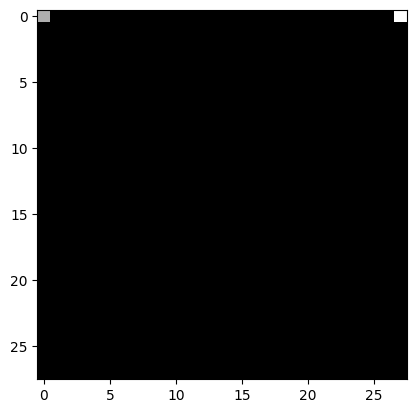

In [247]:
import time
from torchvision.transforms import ToTensor

enc.to(device)
gen.to(device)
disc.to(device)

enc_opt.zero_grad()
gen_opt.zero_grad()
disc_opt.zero_grad()
BATCH_SIZE = 64

to_tensor = ToTensor()
all_real_imgs = torch.vstack([to_tensor(train_ds[i][0]).unsqueeze(0) for i in idxs])
z = all_real_imgs[:1]

N_STEPS = len(all_real_imgs) * 100 // BATCH_SIZE
print("Training for steps:", N_STEPS)

for i in range(N_STEPS):
  start = time.monotonic()

  real_imgs = all_real_imgs[offset:offset + BATCH_SIZE].to(device)

  # train discriminator
  for params in enc.parameters(): params.requires_grad = False
  for params in gen.parameters(): params.requires_grad = False
  for params in disc.parameters(): params.requires_grad = True

  enc.eval()
  gen.eval()
  disc.train()

  enc_opt.zero_grad()
  gen_opt.zero_grad()
  disc_opt.zero_grad()
  real_img_disc_out = disc(real_imgs).sigmoid()
  
  with torch.no_grad():
    latent_dim = enc(real_imgs)
    fake_imgs = gen(latent_dim)
  fake_disc_out = disc(fake_imgs).sigmoid()

  y_hat = torch.cat([real_img_disc_out, fake_disc_out])
  y_true = torch.cat([torch.ones_like(real_img_disc_out), torch.zeros_like(fake_disc_out)])
  disc_loss = F.binary_cross_entropy(y_hat, y_true)
  disc_loss /= 2  # because we have 2x batch_size
  disc_loss.backward()
  disc_opt.step()
  disc_opt.zero_grad()

  # train encoder-generator
  for params in enc.parameters(): params.requires_grad = True
  for params in gen.parameters(): params.requires_grad = True
  for params in disc.parameters(): params.requires_grad = False
  enc.train()
  gen.train()
  disc.eval()
  enc_opt.zero_grad()
  gen_opt.zero_grad()
  latent_dim = enc(real_imgs)
  fake_img = gen(latent_dim)
  disc_out = disc(fake_img).sigmoid()
  gen_loss = F.binary_cross_entropy(disc_out, torch.ones_like(disc_out))# + F.mse_loss(fake_img.flatten(), real_imgs.flatten()) # discriminator just learns too quickly
  gen_loss.backward()
  enc_opt.step()
  gen_opt.step()
  enc_opt.zero_grad()
  gen_opt.zero_grad()

  end = time.monotonic()
  # offset = (offset + BATCH_SIZE) % len(all_real_imgs)

  print(f"Step: {i:4d} | Gen Loss: {gen_loss.item():.4f} | Disc Loss: {disc_loss.item():.4f} | Offset: {offset} | Time: {end - start:.2f} s")

  if i % 100 == 0:
    latent_dim = enc(z.to(device))
    img = gen(latent_dim)
    plt.imshow(img.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.savefig(f"images/{i}.png")


In [142]:
fake_imgs.size()

torch.Size([64, 1, 112, 112])

In [145]:
latent_dim.size()

torch.Size([64, 32, 28, 28])

In [194]:
fake_imgs.size()

torch.Size([64, 1, 28, 28])

In [195]:
real_imgs.size()

torch.Size([64, 1, 28, 28])

In [198]:
((fake_imgs.flatten() - real_imgs.flatten()) ** 2).mean()

tensor(0.1262, device='mps:0')

In [199]:
((fake_imgs.flatten(1) - real_imgs.flatten(1)) ** 2).mean()

tensor(0.1262, device='mps:0')

In [200]:
((real_imgs.flatten() - real_imgs.flatten()) ** 2).mean()

tensor(0., device='mps:0')

ValueError: only one element tensors can be converted to Python scalars

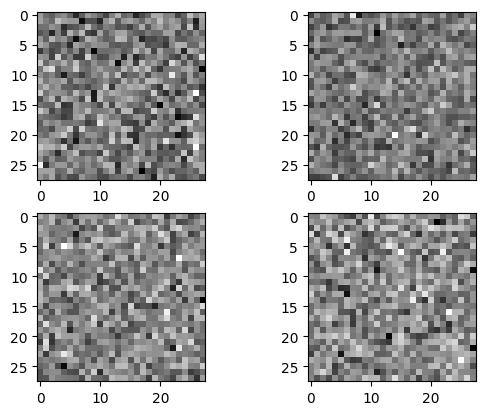

In [2]:
import torch
import matplotlib.pyplot as plt

a = torch.randn(4, 1, 28, 28)
imgs = [x for x in a.squeeze(1)]

# plot all images
fig, axs = plt.subplots(2, 2)
for i, img in enumerate(imgs):
  axs[i // 2, i % 2].imshow(img.numpy(), cmap='gray')